# Convex Optimization - Homework 3

<br> <br>

## Question 1

(LASSO) can be rewritten as:

$$ min\frac{1}{2} ||z||_2^2 + \lambda ||\omega||_1 $$
$$s.t. X \omega - y = z$$

Thus the Lagrangian:


$$\begin{align}
\cal{L}(\omega, z, \nu) &= \frac{1}{2} ||z||_2^2 + \lambda ||\omega||_1 + \nu^t(X \omega - y - z) \\
						&= \frac{1}{2} ||z||_2^2 - \nu^t z + \lambda ||\omega||_1 + \nu^t X \omega - \nu^ty \\ 
						&= \frac{1}{2} ( ||z||_2^2 - 2 \nu^t z) + \lambda ( ||\omega||_1 + \frac{1}{\lambda}\nu^t X \omega )- \nu^ty 
\end{align}
$$

The dual function is thus:

$$\begin{align}
g(\nu) 	&= inf_{\omega , z}  \frac{1}{2} ( ||z||_2^2 - 2 \nu^t z) + \lambda ( ||\omega||_1 + \frac{1}{\lambda}\nu^t X \omega )- \nu^ty \\ 
		&= inf_{z}  \frac{1}{2} ( ||z||_2^2 - 2 \nu^t z) + inf_{\omega} \lambda ( ||\omega||_1 + \frac{1}{\lambda}\nu^t X \omega )- \nu^ty 
\end{align}
$$

We recognize the expression of the the conjugate of the 1-norm evaluated in $(-\frac{1}{\lambda}X^t\nu)$ 
$$\begin{align}
   &inf_{\omega} \lambda ( ||\omega||_1 + \frac{1}{\lambda}\nu^t X \omega ) \\ 
  = &inf_{\omega} \lambda ( ||\omega||_1 -(-\frac{1}{\lambda}\nu^t X \omega) ) \\
  = &-sup_{\omega} \lambda ((-\frac{1}{\lambda}\nu^t X \omega) - ||\omega||_1  ) 
\end{align}$$

And from, a previous homework, we have computed the value of the conjugate of this norm:

$|| \cdot ||^*(-\frac{1}{\lambda}X^t\nu) = \infty$  if $  ||(-\frac{1}{\lambda}X^t\nu) ||_{\infty} > 1 $ <br>
$|| \cdot ||^*(-\frac{1}{\lambda}X^t\nu)  = 0 $  otherwise


<br><br>


By differentiation of a convex and differentiable function, and finding the the value where the gradient is null,we have that  $inf_{z}  \frac{1}{2} ( ||z||_2^2 - 2 \nu^t z)$ is reached when $2z - 2\nu = 0$, thus:

$$ inf_{z}  \frac{1}{2} ( ||z||_2^2 - 2 \nu^t z) = - \frac{1}{2} ||\nu||^2$$




Thus finally:

$ g(\nu) = - \frac{1}{2} ||\nu||^2  - \nu^ty $ if $  ||(-\frac{1}{\lambda}X^t\nu) ||_{\infty} \leq 1 $ <br>
$ g(\nu) = - \infty $ otherwise



The dual problem thus can be written as:


$$ max_{\nu} - \frac{1}{2} ||\nu||^2  - \nu^ty $$
$$s.t. ||(-\frac{1}{\lambda}X^t\nu) ||_{\infty} \leq 1 $$



We want to rewrite the constraint $||(-\frac{1}{\lambda}X^t\nu) ||_{\infty} \leq 1$ as $A\nu \preccurlyeq b$

However: $$||(-\frac{1}{\lambda}X^t\nu) ||_{\infty} \leq 1  \iff   |X^t\nu| \preccurlyeq \lambda 1_n $$
(here the absolute value is applied termwise and $1_n$ is the vector of ones of size $n$)

$$ \iff  X^t\nu \preccurlyeq \lambda 1_n and  -X^t\nu \preccurlyeq \lambda 1_n $$


Thus by stacking $X^t$ and $-X^t$, we make an appropriate matrix $A$.

Thus the dual expressed as: 

$$ min_\nu \nu^t Q \nu + p^t\nu$$
$$ s.t. A \nu \preccurlyeq b$$


with:
* $Q = \frac{1}{2} I_n$
* $p = y^t$
* $ A = \begin{pmatrix} X^t \\ - X^t \\ \end{pmatrix} $
* $b = \lambda 1_{2d}$





## Question 2

In [1]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

Let's compute the necessary derivative terms for the barrier method: <br> <br>
The gradient of $f:v \mapsto t(v^tQv + p^tv)  - \sum_i^{2d} log(-(Av-b)_i)$ is:


$$\nabla f (v) = t(2Qv + p) - \sum_i^{2d} \frac{A_i^t}{b-A_iv}$$
where $A_i$ is the $i^{th}$ line of $A$.


Therefore, the component $(k,l)$ of the hessian of $f$ is:

$$\nabla^2 f(v)_{k,l} = \sum_{i=1}^{2d} \frac{A_{ik}A_{il}}{(b-A_iv)^2}$$

And we almost recognize the component $k,l$ of $A^tA$ , but where each line $i$ of A has been divided by  $(b-A_iv)^2$. <br>
Therefore: $$\nabla^2 f(v) = A^t diag(1/(b-Av)_i) A  $$ 

In [2]:
def f0(v, Q, p):
    return v.T@Q@v + p.T@v


def f(v, t, Q, A, p, b):
    return t*f0(v, Q, p) - np.sum(np.log(b - A @ v))


def centering_step(Q, p, A, b, t, v0, eps, return_iter_number  = True):
    v = v0
    v_list = [v0]

    lambda_2 = 1000

    # Newton method loop
    iter_number = 0
    while lambda_2 / 2 > eps:
        iter_number += 1
        # Compute gradient and hessian
        grad_f = t*(2*Q@v + p) - A.T @ (1./(b- A@v))
        hessian_f = 2*t*Q + A.T@ np.diag(1. / (b - A @ v))**2 @ A

        delta_v = - np.linalg.pinv(hessian_f) @ grad_f
        lambda_2 =  - grad_f.T @ delta_v

        # Backtracking line search
        alpha = 0.25
        beta = 0.5
        t_newton = 1.

        while (b - A @ (v + t_newton*delta_v) <= 0).any() or f(v + t_newton*delta_v, t, Q, A, p, b) >= f(v, t, Q, A, p, b) + t_newton*alpha*grad_f.T @ delta_v:
            t_newton *= beta
            # When t_newton doesn't evolve (is stuck at 0) we can stop the backtracking line search
            if t_newton == 0:
                return (v_list, iter_number)

        v = v + t_newton*delta_v
        v_list.append(v)



    return (v_list, iter_number)


In [3]:
def barr_method(Q, p, A, b, v0, epss, mu = 2, return_iter_and_precision = False):
    m = b.shape[0]
    t  = 1.
    v_list = []
    iter_numbers = []
    precision = []

    # Iteration until precision is achieved
    while m/t  >= epss:
        values, iter_nb =  centering_step(Q,p,A,b,t,v0,epss, return_iter_number=True)

        # Save values
        v_list.append(values[-1])
        iter_numbers.append(iter_nb)
        precision.append(m/t)	

        # Update t
        t  *= mu

    if return_iter_and_precision:
        return (v_list, iter_numbers, precision)
    else:
        return v_list


In [4]:
# Global parameters
n = 15
d = 100

# Generate regression data
X = np.random.randn(n,d)
omega = np.random.random_sample(d)
y = X@omega + 0.25*np.random.randn(n)

# Problem variables
Q = 0.5*np.eye(n)
p = -y
v0 = np.zeros(n)
eps = 10e-5
A = np.concatenate((X.T, -X.T), axis = 0)
lam = 10
b = lam * np.ones(2*d)
p = -y




In [5]:
mu_list = [2,15,50,100, 250]
results = {}
for mu in mu_list:
    results[mu] = barr_method(Q, y, A, b, v0, eps, mu, return_iter_and_precision=True)

plt.show()

Below I plotted the precision criterion and the gap depending of the iteration number.
The 2 first plots take only the barrier method iterations in account, the last one also take the centering steps iterations (non neglectable).
For the last plot, I plotted a constant gap during the centering steps iterations because it the function value is ot updated during those.

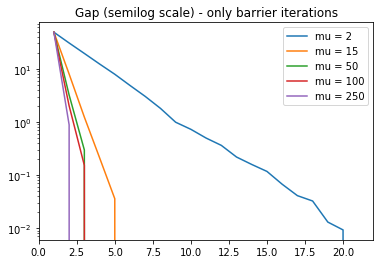

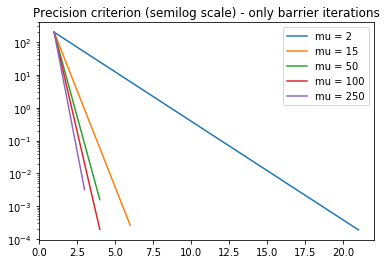

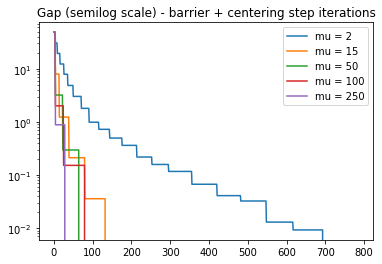

In [6]:
# Gap value (barrier iterations only)
for mu in mu_list:
    v_values, iter_nb, precisions = results[mu]
    v_star = v_values[-1]
    log_diff =np.array([f0(v_star, Q, p) - f0(v, Q, p) for v in v_values])
    plt.yscale("log")
    plt.plot([i+1 for i in range(len(v_values))], log_diff, label = "mu = " + str(mu))
plt.title("Gap (semilog scale) - only barrier iterations")
plt.legend()
plt.show()


# Precision citerion (barrier iterations only)
for mu in mu_list:
    v_values, iter_nb, precisions = results[mu]
    plt.yscale("log")
    plt.plot([i+1 for i in range(len(v_values))], precisions, label = "mu = " + str(mu))
plt.title("Precision criterion (semilog scale) - only barrier iterations")
plt.legend()
plt.show()


# Gap value (barrier + centering step iterations)
for mu in mu_list:
    v_values, iter_nb, precisions = results[mu]
    v_star = v_values[-1]
    log_diff =np.array([f0(v_star, Q, p) - f0(v, Q, p) for v in v_values])
    A = np.concatenate([ [log_diff[i]]*cst_iter for i,cst_iter in enumerate(iter_nb)])
    plt.plot(range(A.shape[0]), A, label = "mu = " + str(mu) )
plt.yscale("log")
plt.legend()
plt.title("Gap (semilog scale) - barrier + centering step iterations")
plt.show()	

Here, the value of $\mu$ does not seem to affect negatively the convergence of the algorithm. For $\mu = 15$, we reach a convergence seed that is hardly distinguishable from ones with higher $\mu$. We could advice an intermediate value of $\mu = 50$ for both convergence speed and robustness of convergence.